In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time
import re
import nltk
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import PCA

In [4]:
#QUESTION1
start_time = time.time()

def state_count(loc):
    count = sum([1 for state in states if state in loc])
    if "arkansas" in loc:
        count = count - 1
    return count

tweets_us_df = pd.read_csv("/Users/revan/Downloads/us_tweets_sample.csv")
tweets_us_df.shape[0] #2,000,000
tweets_us_df.drop_duplicates(subset = ['status_id'], inplace=True)
tweets_us_df.shape[0] #2,000,000 so no duplicates
tweets_us_df = tweets_us_df.sample(n=500000, random_state=42)
us_states_df = pd.read_excel("/Users/revan/Downloads/us_states.xlsx")
tweets_us_df['location'] = tweets_us_df['location'].str.lower()
#tweets_us_df['location'].head(10) 
us_states_df['state'] = us_states_df['state'].str.lower()
us_states_df['region'] = us_states_df['region'].str.lower()
#us_states_df.head(10)
states = us_states_df['state'].tolist() 
#states.append("hawai'i")
tweets_us_df['state_count'] = tweets_us_df['location'].map(state_count)
tweets_us_df[tweets_us_df['state_count'] == 1].shape

print(tweets_us_df[tweets_us_df['state_count'] == 1].shape)
elapsed_time = time.time() - start_time
print(elapsed_time)

(498707, 33)
38.93293380737305


In [5]:
#QUESTION2
start_time = time.time()

tweets_us_df['day'] = pd.to_datetime(tweets_us_df['created_at'], format="%Y-%m-%d")
tweets_us_df['day'] = tweets_us_df['day'].dt.strftime("%Y-%m-%d")
#tweets_us_df['day'].head(10)

def get_state(location):
    for state in states:
        if state in location:
            return state
    return None

tweets_us_df['state'] = tweets_us_df['location'].map(get_state)
region_dict = us_states_df.set_index('state').to_dict()['region']
tweets_us_df['region'] = tweets_us_df['state'].map(region_dict)
#tweets_us_df[['state', 'location','region']].head(10)

elapsed_time = time.time() - start_time
print(elapsed_time)

2.483999252319336


In [6]:
#QUESTION 3
STOP_WORDS = set(stopwords.words('english'))

def tweet_cleaner(tweet):
    tweet = tweet.lower() #convert all chars to lowercase  
    #tweet = tweet[2:] #removes first two chars
    tweet = re.sub("@[A-Za-z0-9]+","", tweet) #Remove @ sign
    tweet = re.sub("#[A-Za-z0-9_]+","", tweet) #removes hashtags 
    tweet = re.sub(r'[^\w\s]', " ", tweet) #removes punctuation
    tweet = re.sub(r"http\S+", "", tweet) #removes links
    tweet = remove_emojis(tweet)
    words = nltk.word_tokenize(tweet)
    tweet = [word for word in words if word not in STOP_WORDS] #removes words such as a, for, an, nor, but, or, yet, so
    tweet = [word for word in words if len(word) > 3 and not re.match(r'\d+',  word)]
    return ' '.join(tweet)

def remove_emojis(tweet):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)
    

In [7]:
#QUESTION 4

lemmatizer = WordNetLemmatizer()

##Tags the words in the tweets
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return(wordnet.ADJ)
    elif nltk_tag.startswith('V'):
        return(wordnet.VERB)
    elif nltk_tag.startswith('N'):
        return(wordnet.NOUN)
    elif nltk_tag.startswith('R'):
        return(wordnet.ADV)
    else:
        return(None)

##Lemmatizes the words in tweets and returns the cleaned and lemmatized tweet
def lemmatize_tweet(tweet):
    #tokenize the tweet and find the POS tag for each token
    tweet = tweet_cleaner(tweet) #tweet_cleaner() will be the function you will write
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(tweet))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_tweet = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_tweet.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_tweet.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_tweet))

In [8]:
#tweets_us_df = tweets_us_df[:10000]

In [9]:
start_time = time.time()

tweets_us_df["clean_tweet"] = tweets_us_df["text"].map(lemmatize_tweet)

elapsed_time = time.time() - start_time
print(elapsed_time)

632.7841508388519


In [10]:
#Question 5

start_time = time.time()

isolation_df = pd.read_excel("/Users/revan/Downloads/medicine_words.xlsx")
medicine_df = pd.read_excel("/Users/revan/Downloads/isolation_words.xlsx")
disinfectant_df = pd.read_excel("/Users/revan/Downloads/disinfectant_words.xlsx")
vaccine_df = pd.read_excel("/Users/revan/Downloads/vaccine_words.xlsx")

isolation_df['words'] = isolation_df['words'].str.lower()
medicine_df['words'] = medicine_df['words'].str.lower()
disinfectant_df['words'] = disinfectant_df['words'].str.lower()
vaccine_df['words'] = vaccine_df['words'].str.lower()

def lemmatize_word(words):
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(words))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_words = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_words.append(word)
        else:
            #else use the tag to lemmatize the token
            lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return(" ".join(lemmatized_words))

isolation_df['lemmatized_words'] = isolation_df["words"].map(lemmatize_word)
medicine_df['lemmatized_words'] = medicine_df["words"].map(lemmatize_word)
disinfectant_df['lemmatized_words'] = disinfectant_df["words"].map(lemmatize_word)
vaccine_df['lemmatized_words'] = vaccine_df['words'].map(lemmatize_word)

#tweets_us_df[["clean_tweet", "text"]].head(50)
#tweets_us_df[tweets_us_df.text.str[0:2] == "‘b"][['text', 'clean_text']].head(20)
#medicine_df.head(10)

WORD = re.compile(r"\w+")


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x] ** 2 for x in list(vec1.keys())])
    sum2 = sum([vec2[x] ** 2 for x in list(vec2.keys())])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    words = WORD.findall(text)
    return Counter(words)

isolation_vec = text_to_vector(" ".join(isolation_df['lemmatized_words'].tolist()))
medicine_vec = text_to_vector(" ".join(medicine_df['lemmatized_words'].tolist()))
disinfectant_vec = text_to_vector(" ".join(disinfectant_df['lemmatized_words'].tolist()))
vaccine_vec = text_to_vector(" ".join(vaccine_df['lemmatized_words'].tolist()))

tweets_us_df['isolation_cosine'] = tweets_us_df['clean_tweet'].map( lambda tweet: get_cosine(text_to_vector(tweet), isolation_vec))
tweets_us_df['medicine_cosine'] = tweets_us_df['clean_tweet'].map( lambda tweet: get_cosine(text_to_vector(tweet), medicine_vec))
tweets_us_df['disinfectant_cosine'] = tweets_us_df['clean_tweet'].map( lambda tweet: get_cosine(text_to_vector(tweet), disinfectant_vec))
tweets_us_df['vaccine_cosine'] = tweets_us_df['clean_tweet'].map( lambda tweet: get_cosine(text_to_vector(tweet), vaccine_vec))

tweets_us_df['isolation_cosine_normal'] = MinMaxScaler().fit_transform(np.array(tweets_us_df['isolation_cosine']).reshape(-1,1))
tweets_us_df['medicine_cosine_normal'] = MinMaxScaler().fit_transform(np.array(tweets_us_df['medicine_cosine']).reshape(-1,1))
tweets_us_df['disinfectant_cosine_normal'] = MinMaxScaler().fit_transform(np.array(tweets_us_df['disinfectant_cosine']).reshape(-1,1))
tweets_us_df['vaccine_cosine_normal'] = MinMaxScaler().fit_transform(np.array(tweets_us_df['vaccine_cosine']).reshape(-1,1))

elapsed_time = time.time() - start_time
print(elapsed_time)

248.73250699043274


In [11]:
start_time = time.time()

cosine_columns = ['isolation_cosine_normal', 'medicine_cosine_normal', 'disinfectant_cosine_normal', 'vaccine_cosine_normal']
state_topic_score_data_df = tweets_us_df[['state'] + cosine_columns].groupby('state').mean()
state_topic_score_data_df.to_csv('/Users/revan/Downloads/state_topic_score_data.csv')

region_topic_score_data_df = tweets_us_df[['region'] + cosine_columns].groupby('region').mean()
region_topic_score_data_df.to_csv('/Users/revan/Downloads/region_topic_score_data.csv')

elapsed_time = time.time() - start_time
print(elapsed_time)

1.1334490776062012


In [17]:
#QUESTION 7
kmeans = KMeans(n_clusters = 4)
x = state_topic_score_data_df.copy()
x_values = x.values.copy()
kmeans.fit(x_values)
x['kmeans_labels'] = kmeans.labels_
#x['region'] = x.index.map(region_dict)

#x.sort_values(by=['kmeans_labels'])

In [111]:
x.sort_values(by=['kmeans_labels'])

,isolation_cosine_normal,medicine_cosine_normal,disinfectant_cosine_normal,vaccine_cosine_normal,kmeans_labels
state,,,,,
wyoming,0.016356,0.004997,0.006845,0.017027,0
new hampshire,0.016096,0.005149,0.007853,0.016326,0
wisconsin,0.016971,0.005173,0.006681,0.016847,0
new jersey,0.016721,0.006563,0.006932,0.017340,0
north carolina,0.017039,0.005510,0.007132,0.017161,0
maine,0.016055,0.005304,0.006822,0.016867,0
louisiana,0.016314,0.004974,0.007361,0.017524,0
nebraska,0.018013,0.005823,0.007538,0.016036,0
hawaii,0.015620,0.006829,0.006207,0.016873,0


In [66]:
clustering = SpectralClustering(n_clusters = 4)
y = state_topic_score_data_df.copy()
clustering.fit(y.values)
y['spectral_labels'] = clustering.labels_
#y['region'] = y.index.map(region_dict)

#y.sort_values(by=['spectral_labels'])

In [112]:
y.sort_values(by=['spectral_labels'])

,isolation_cosine_normal,medicine_cosine_normal,disinfectant_cosine_normal,vaccine_cosine_normal,spectral_labels
state,,,,,
wyoming,0.016356,0.004997,0.006845,0.017027,0
nevada,0.016742,0.005230,0.006815,0.015836,0
maine,0.016055,0.005304,0.006822,0.016867,0
louisiana,0.016314,0.004974,0.007361,0.017524,0
new hampshire,0.016096,0.005149,0.007853,0.016326,0
north carolina,0.017039,0.005510,0.007132,0.017161,0
south carolina,0.017497,0.005297,0.007143,0.017244,0
florida,0.016694,0.005201,0.006797,0.016594,0
wisconsin,0.016971,0.005173,0.006681,0.016847,0


In [67]:
#QUESTION 8

def calculate_score(x, n, method):
    if method == "kmeans":
        model = KMeans(n_clusters = n)
    elif method == 'clustering': 
        model = SpectralClustering(n_clusters = n)
    model.fit(x)
    return calinski_harabasz_score(x, model.labels_)


km_scores = pd.DataFrame({'clusters':  range(2,21)})
km_scores['k_means_score'] = km_scores['clusters'].map(lambda n: calculate_score(x, n, 'kmeans'))
km_scores['clustering_score'] = km_scores['clusters'].map(lambda n: calculate_score(y, n, 'clustering'))

<AxesSubplot:>

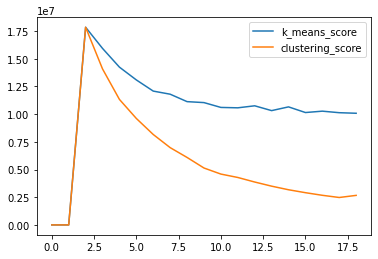

In [19]:
km_scores[['k_means_score','clustering_score']].plot()

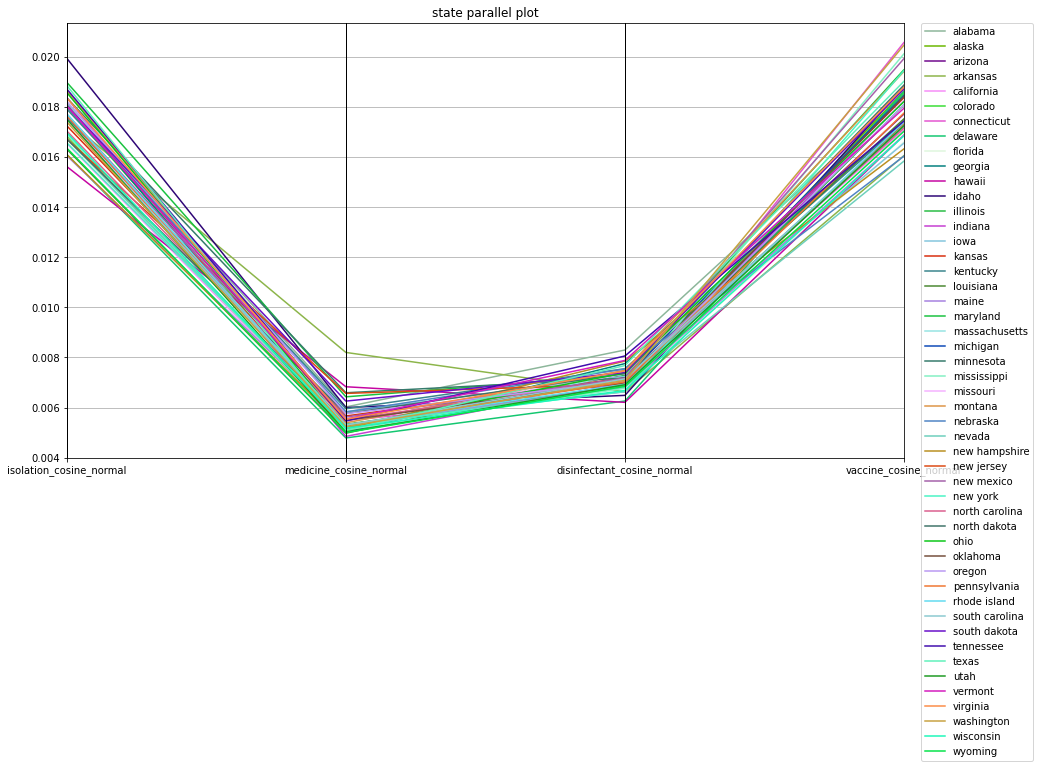

In [56]:
#QUESTION 9
col_names = ['isolation_cosine_normal', 'medicine_cosine_normal', 'disinfectant_cosine_normal', 'vaccine_cosine_normal', 'state']
plt.figure(figsize=(15,8))
pd.plotting.parallel_coordinates(state_topic_score_data_df.reset_index()[col_names], class_column='state')
plt.title("state parallel plot")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

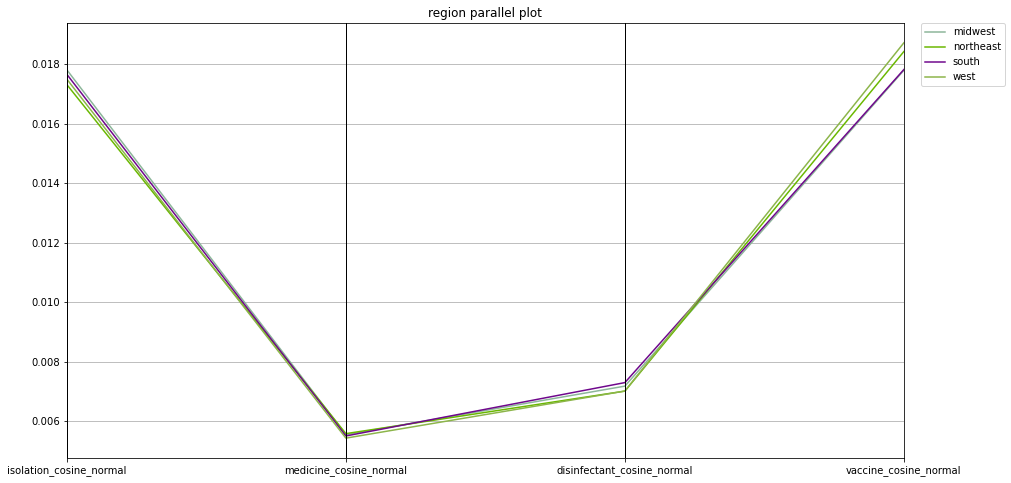

In [57]:
col_names2 = ['isolation_cosine_normal', 'medicine_cosine_normal', 'disinfectant_cosine_normal', 'vaccine_cosine_normal', 'region']
plt.figure(figsize=(15,8))
pd.plotting.parallel_coordinates(region_topic_score_data_df.reset_index()[col_names2], class_column='region')
plt.title("region parallel plot")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [80]:
cluster_df.head(10)

,isolation_cosine_normal,medicine_cosine_normal,disinfectant_cosine_normal,vaccine_cosine_normal,kmeans_labels
state,,,,,
alabama,0.018193,0.006024,0.008296,0.018516,3
alaska,0.016846,0.005079,0.006901,0.018633,1
arizona,0.017569,0.005431,0.007306,0.017720,2
arkansas,0.017484,0.008199,0.006627,0.016057,0
california,0.016544,0.005183,0.007199,0.017089,0
colorado,0.017995,0.005311,0.006881,0.018540,3
connecticut,0.018609,0.005474,0.006627,0.020573,1
delaware,0.016106,0.004786,0.006259,0.018611,1
florida,0.016694,0.005201,0.006797,0.016594,0


/Users/revan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


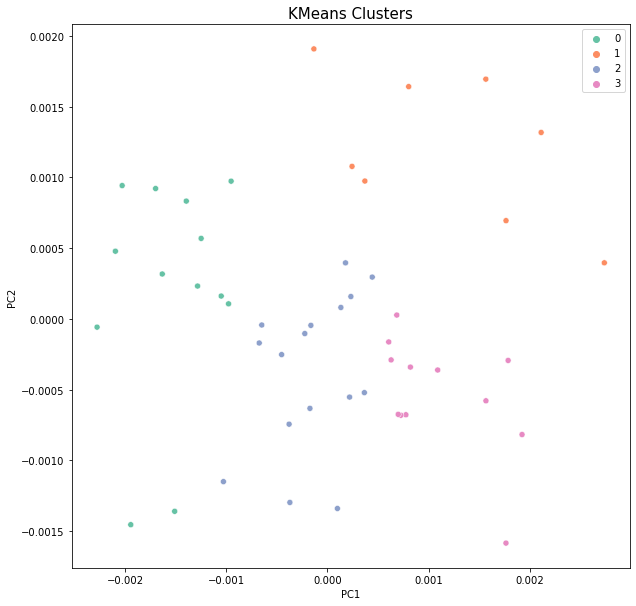

In [109]:
cluster_df = x.copy()
spectral_df = y.copy()
pca1 = PCA(n_components=2)
pca_labels =['0','1','2','3']
cluster_pca = pca1.fit_transform(cluster_df[cosine_columns].values)

#plt.scatter(cluster_pca[:,0], cluster_pca[:,1], c=cluster_df['kmeans_labels'])
#plt.legend(pca_labels, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.figure(figsize = (10,10))
sns.scatterplot(cluster_pca[:,0], cluster_pca[:,1], 
                hue=kmeans.labels_, palette='Set2').set_title('KMeans Clusters', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()



/Users/revan/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


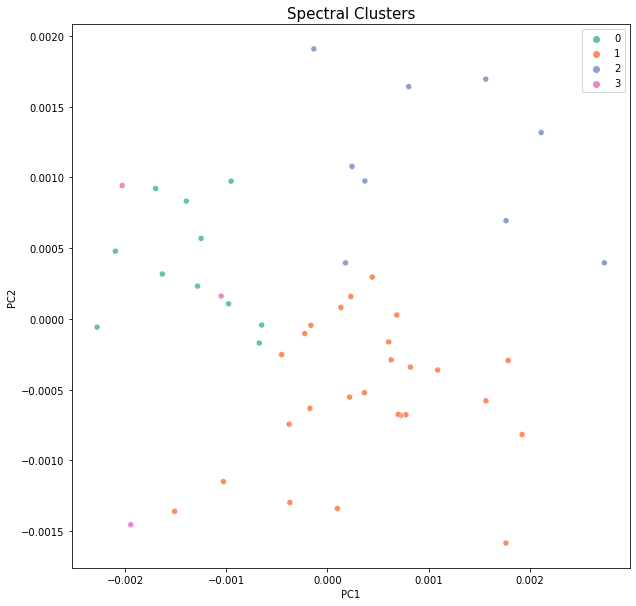

In [110]:
pca2 = PCA(n_components=2)
spectral_pca = pca2.fit_transform(spectral_df[cosine_columns].values)

plt.figure(figsize = (10,10))
sns.scatterplot(spectral_pca[:,0], spectral_pca[:,1], 
                hue=clustering.labels_, palette='Set2').set_title('Spectral Clusters', fontsize=15)
plt.legend()
plt.ylabel('PC2')
plt.xlabel('PC1')
plt.show()
